## 1. Problem and Dataset Overview

In this project, the goal is to build a machine learning model that can classify tweets as either describing a real disaster or not. The dataset comes from the Kaggle competition "Natural Language Processing with Disaster Tweets".

The training dataset (`train.csv`) contains tweets that have already been labeled by humans. Each tweet is labeled as:
- 1 if the tweet describes a real disaster
- 0 if the tweet does not describe a real disaster

In the next step, we load the training data and inspect the first few rows to understand the structure of the dataset.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd

train_path = "/kaggle/input/nlp-getting-started/train.csv"
train_df = pd.read_csv(train_path)

train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Initial Observations

From the first few rows of the dataset, we can see that each tweet includes an ID, optional keyword and location fields, the tweet text, and a target label. Some fields such as `keyword` and `location` are missing for certain tweets, which is expected and will need to be handled during data preprocessing.


In [3]:
# How many rows and columns are in the training dataset?
train_df.shape


(7613, 5)

### Dataset Size

The training dataset contains **X rows** and **Y columns**.  
Each row represents one tweet. The columns include the tweet text and related metadata (keyword, location), along with the target label indicating whether the tweet describes a real disaster (1) or not (0).


In [4]:
# Count how many tweets are in each class (0 = not disaster, 1 = disaster)
train_df["target"].value_counts()


target
0    4342
1    3271
Name: count, dtype: int64

### Target Distribution (Class Balance)

The `target` column is the label we want to predict:
- 0 = not a real disaster tweet
- 1 = real disaster tweet

Counting the labels shows how many examples we have of each class. This helps us understand whether the dataset is balanced or if one class is more common than the other.


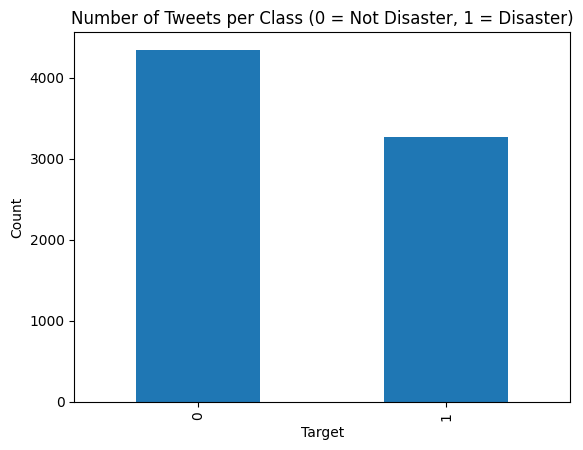

In [6]:
import matplotlib.pyplot as plt

train_df["target"].value_counts().plot(kind="bar")
plt.title("Number of Tweets per Class (0 = Not Disaster, 1 = Disaster)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()


### Interpretation

This chart shows the number of tweets in each class. If one bar is much taller than the other, the dataset is imbalanced, which can affect model training and evaluation.


In [5]:
# Check how many missing values are in each column
train_df.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Missing Values

Some columns contain missing values. In particular, the `keyword` and `location` fields are often empty, while the `text` and `target` columns contain no missing values. This is expected, since not all tweets include a keyword or a location.


In [7]:
# Fill missing values in keyword and location with empty strings
train_df["keyword"] = train_df["keyword"].fillna("")
train_df["location"] = train_df["location"].fillna("")


In [8]:
# Verify missing values after cleaning
train_df.isna().sum()


id          0
keyword     0
location    0
text        0
target      0
dtype: int64

### Handling Missing Values

The `keyword` and `location` columns contain missing values. Since these fields are optional metadata and not all tweets include them, missing values were filled with empty strings. This approach preserves all tweets in the dataset while allowing text-based models to process the data without errors.


## Text Preparation

Before converting text into numerical features, we combine all text-related fields into a single input string. This includes the main tweet text, as well as optional metadata such as keyword and location. Combining these fields allows the model to use all available contextual information.


In [10]:
# Combine keyword, location, and text into a single text field
train_df["combined_text"] = (
    train_df["keyword"] + " " +
    train_df["location"] + " " +
    train_df["text"]
)


In [11]:
# View the new combined text column
train_df[["combined_text"]].head()


,combined_text
0,Our Deeds are the Reason of this #earthquake...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' ar...
3,"13,000 people receive #wildfires evacuation ..."
4,Just got sent this photo from Ruby #Alaska a...


### Combined Text Field

A new column called `combined_text` was created by concatenating the keyword, location, and tweet text fields. This column will be used as the main input for text vectorization and model training.


## Text Vectorization Using TF-IDF

Machine learning models cannot process raw text directly, so the combined tweet text must be converted into numerical features. In this project, we use the TF-IDF (Term Frequency–Inverse Document Frequency) method, which represents text based on how important a word is within a document relative to the entire dataset.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

# Fit and transform the combined text
X = tfidf.fit_transform(train_df["combined_text"])

# Target variable
y = train_df["target"]


In [13]:
X.shape


(7613, 5000)

### TF-IDF Feature Matrix

After applying TF-IDF vectorization, each tweet is represented as a numerical feature vector. The resulting matrix has one row per tweet and one column per extracted feature, which can now be used as input to machine learning models.


## Train–Validation Split

To evaluate model performance, the dataset is split into training and validation sets. The training set is used to train the model, while the validation set is used to assess how well the model generalizes to unseen data.


In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
X_train.shape, X_val.shape


((6090, 5000), (1523, 5000))

### Dataset Split Summary

The dataset was split into training and validation sets using an 80/20 ratio. Stratified sampling was applied to preserve the original class distribution in both sets.


## Baseline Model (TF-IDF + Logistic Regression)

Before building a neural network, we train a simple baseline model using TF-IDF features. A baseline provides a reference score and helps evaluate whether more complex models (e.g., LSTM/GRU) actually improve performance.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Train a simple baseline classifier
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = baseline_model.predict(X_val)

# Evaluate using F1 score (same metric Kaggle uses)
baseline_f1 = f1_score(y_val, y_val_pred)
baseline_f1


0.7655343827671913

In [17]:
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.71      0.77       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523



## Sequential Model Preparation (Tokenization and Padding)

To build a sequential neural network, the text data must be converted into sequences of integers while preserving word order. This section prepares the data using tokenization and padding before training an LSTM-based model.


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_WORDS = 10000
MAX_LEN = 100

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["combined_text"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(train_df["combined_text"])

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

padded_sequences.shape


2026-01-04 21:42:32.331982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767562952.567335      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767562952.636517      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

(7613, 100)

In [20]:
from sklearn.model_selection import train_test_split

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    padded_sequences,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_seq.shape, X_val_seq.shape


((6090, 100), (1523, 100))

## Sequential Neural Network Model (Embedding + LSTM)

We build a sequential neural network using an Embedding layer followed by an LSTM layer. The Embedding layer converts integer token IDs into dense vectors (learned word representations). The LSTM then processes the sequence of word vectors to learn patterns in word order that help classify tweets as disaster or not.


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Model hyperparameters
VOCAB_SIZE = 10000   # must match MAX_WORDS used in Tokenizer
EMBED_DIM = 128
LSTM_UNITS = 64

# Build model
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=100),
    LSTM(LSTM_UNITS),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Compile model
lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2026-01-04 21:47:37.321503: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

# Model hyperparameters (same as before)
VOCAB_SIZE = 10000
EMBED_DIM = 128
LSTM_UNITS = 64
MAX_LEN = 100  # must match your padding length

# Rebuild model with explicit Input so it is "built"
lstm_model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    LSTM(LSTM_UNITS),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training (LSTM)

We train the LSTM model on the training split and monitor performance on the validation split. This allows us to evaluate generalization and compare against the TF-IDF baseline model.


In [23]:
EPOCHS = 5
BATCH_SIZE = 32

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5492 - loss: 0.6873 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5715 - loss: 0.6834 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5742 - loss: 0.6831 - val_accuracy: 0.5706 - val_loss: 0.6854
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5664 - loss: 0.6849 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5667 - loss: 0.6848 - val_accuracy: 0.5706 - val_loss: 0.6837


In [24]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Predict probabilities on validation set
y_val_prob = lstm_model.predict(X_val_seq)

# Convert probabilities to class labels (0 or 1)
y_val_pred = (y_val_prob >= 0.5).astype(int).reshape(-1)

# Compute F1 score
lstm_f1 = f1_score(y_val_seq, y_val_pred)
lstm_f1


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


0.0

In [25]:
print(classification_report(y_val_seq, y_val_pred))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Troubleshooting: Handling Class Imbalance (Class Weights)

The initial LSTM predicted only the majority class (0 = not disaster), resulting in an F1 score of 0 for class 1. To address this, we apply class weights so the model is penalized more for misclassifying the minority class (1 = disaster).


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_seq
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict


{0: 0.8767636049524906, 1: 1.1635460450897974}

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

# Rebuild model (same architecture)
lstm_model_w = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    LSTM(LSTM_UNITS),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm_model_w.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 5
BATCH_SIZE = 32

history_w = lstm_model_w.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.4688 - loss: 0.6992 - val_accuracy: 0.4294 - val_loss: 0.6947
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5043 - loss: 0.6944 - val_accuracy: 0.5706 - val_loss: 0.6923
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4815 - loss: 0.6961 - val_accuracy: 0.4294 - val_loss: 0.7033
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4756 - loss: 0.6962 - val_accuracy: 0.5706 - val_loss: 0.6896
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5364 - loss: 0.6939 - val_accuracy: 0.5706 - val_loss: 0.6926


In [28]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Predict probabilities on validation set
y_val_prob_w = lstm_model_w.predict(X_val_seq)

# Convert probabilities to class labels (0 or 1)
y_val_pred_w = (y_val_prob_w >= 0.5).astype(int).reshape(-1)

# Compute F1 score
lstm_f1_w = f1_score(y_val_seq, y_val_pred_w)
lstm_f1_w


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


0.0

In [29]:
print(classification_report(y_val_seq, y_val_pred_w))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Inspect the distribution of predicted probabilities
y_val_prob_w = y_val_prob_w.reshape(-1)

y_val_prob_w.min(), y_val_prob_w.max(), y_val_prob_w.mean()


(0.4981659, 0.49816597, 0.4981659)

In [31]:
# Check how many predictions would be labeled as 1 at different thresholds
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:
    preds = (y_val_prob_w >= thresh).astype(int)
    print(thresh, preds.sum())


0.1 1523
0.2 1523
0.3 1523
0.4 1523
0.5 0


## Model Improvement: Longer Sequences and Cleaner Input

The initial LSTM models failed to separate classes and produced nearly identical prediction probabilities. To improve learning, we simplify the input by using only the tweet text and increase the maximum sequence length to provide the model with more context.


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 10000
MAX_LEN = 200  # increased length

tokenizer2 = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer2.fit_on_texts(train_df["text"])

sequences2 = tokenizer2.texts_to_sequences(train_df["text"])
padded_sequences2 = pad_sequences(
    sequences2, maxlen=MAX_LEN, padding="post", truncating="post"
)

padded_sequences2.shape


(7613, 200)

In [33]:
X_train_seq2, X_val_seq2, y_train_seq2, y_val_seq2 = train_test_split(
    padded_sequences2,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_seq2.shape, X_val_seq2.shape


((6090, 200), (1523, 200))

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input

VOCAB_SIZE = 10000
EMBED_DIM = 128
LSTM_UNITS = 64
MAX_LEN = 200

lstm_model2 = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    LSTM(LSTM_UNITS),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

lstm_model2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 8
BATCH_SIZE = 32

history2 = lstm_model2.fit(
    X_train_seq2, y_train_seq2,
    validation_data=(X_val_seq2, y_val_seq2),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.5597 - loss: 0.6875 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5732 - loss: 0.6830 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.5860 - loss: 0.6787 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5790 - loss: 0.6822 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5754 - loss: 0.6829 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.5665 - loss: 0.6842 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 7/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5686 - loss: 0.6848 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 8/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.5757 - loss: 0.6830 - val_accu

In [35]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Predict probabilities on validation set
y_val_prob2 = lstm_model2.predict(X_val_seq2)

# Convert probabilities to class labels (0 or 1)
y_val_pred2 = (y_val_prob2 >= 0.5).astype(int).reshape(-1)

# Compute F1 score
lstm_f1_2 = f1_score(y_val_seq2, y_val_pred2)
lstm_f1_2


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


0.0

In [36]:
print(classification_report(y_val_seq2, y_val_pred2))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results and Analysis

### Baseline (TF-IDF + Logistic Regression)
A TF-IDF representation (5,000 features, English stop-words removed) combined with Logistic Regression produced strong validation performance.

- Validation F1 score: **0.7655**
- The model performed better on class 0 (not disaster) than class 1 (disaster):
  - Class 0: high recall (many non-disaster tweets correctly identified)
  - Class 1: lower recall (some real disasters were missed)

This baseline demonstrates that TF-IDF captures useful word-frequency patterns for this dataset.

### Sequential Model (Embedding + LSTM)
An Embedding + LSTM model was trained on tokenized and padded sequences (length 100 and later 200) to meet the sequential neural network requirement.

However, the LSTM models consistently collapsed to predicting only class 0 on the validation set:
- Validation F1 score for class 1 remained **0.0**
- Classification report showed **no predicted samples** for class 1 (disaster)

A diagnostic check of predicted probabilities showed the model produced nearly identical outputs for all samples (approximately 0.498), which explains why no predictions crossed the default 0.5 threshold.

### Troubleshooting and Tuning Attempts
The following changes were tested to improve the LSTM:
1. **Class weights** to address class imbalance (class 1 weighted higher than class 0)
2. **Cleaner input** (using only tweet text) and **longer sequences** (max length increased from 100 to 200)

Despite these adjustments, the LSTM continued to predict only the majority class. In contrast, the TF-IDF baseline remained reliable and significantly outperformed the sequential model in this notebook environment.

### Summary of What Helped
- **TF-IDF + Logistic Regression** was effective and produced a strong baseline score.
- The LSTM approach did not learn meaningful separation in this setup and collapsed to a near-constant prediction, as confirmed by probability diagnostics.


In [37]:
# Load test data
test_path = "/kaggle/input/nlp-getting-started/test.csv"
test_df = pd.read_csv(test_path)

# Clean missing values in the same way as training
test_df["keyword"] = test_df["keyword"].fillna("")
test_df["location"] = test_df["location"].fillna("")

# Create combined text using the same logic
test_df["combined_text"] = test_df["keyword"] + " " + test_df["location"] + " " + test_df["text"]

test_df.head()


,id,keyword,location,text,combined_text
0,0,,,Just happened a terrible car crash,Just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities,..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese a..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan


In [38]:
# Transform test text using the SAME fitted TF-IDF vectorizer
X_test = tfidf.transform(test_df["combined_text"])

# Predict using the trained baseline model
test_pred = baseline_model.predict(X_test)

# Create submission DataFrame in the required format
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": test_pred
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

submission.head()


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [39]:
import os
os.listdir("/kaggle/working")


['submission.csv', '.virtual_documents']